In [40]:
import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import DUCK_Net
from ImageLoader import ImageLoader2D
import cv2

In [41]:
img_size = 352
learning_rate = 1e-4
seed_value = 58800
filters = 17 
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
model_type = "DuckNet"


In [42]:
X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 40


40it [00:05,  6.90it/s]


In [43]:
model = DUCK_Net.create_model(img_height=img_size, img_width=img_size, input_chanels=3, out_classes=1, starting_filters=filters)

model.compile(optimizer=optimizer, loss=dice_metric_loss)

Starting DUCK-Net


In [44]:
def postproccessing(image):
    kernels = [5, 10, 15]
    for k in kernels: 
        kernel = np.ones((k,k), np.uint8)
        # opening
        erosion1 = cv2.erode(image, kernel, iterations = 1)
        dilation1 = cv2.dilate(erosion1, kernel, iterations = 1)

        # closing
        dilation2 = cv2.dilate(dilation1, kernel, iterations = 1)
        erosion2 = cv2.erode(dilation2, kernel, iterations = 1)
        
        image = erosion2

    return image

Loading the model
10/10 [==============================] - 4s 145ms/step


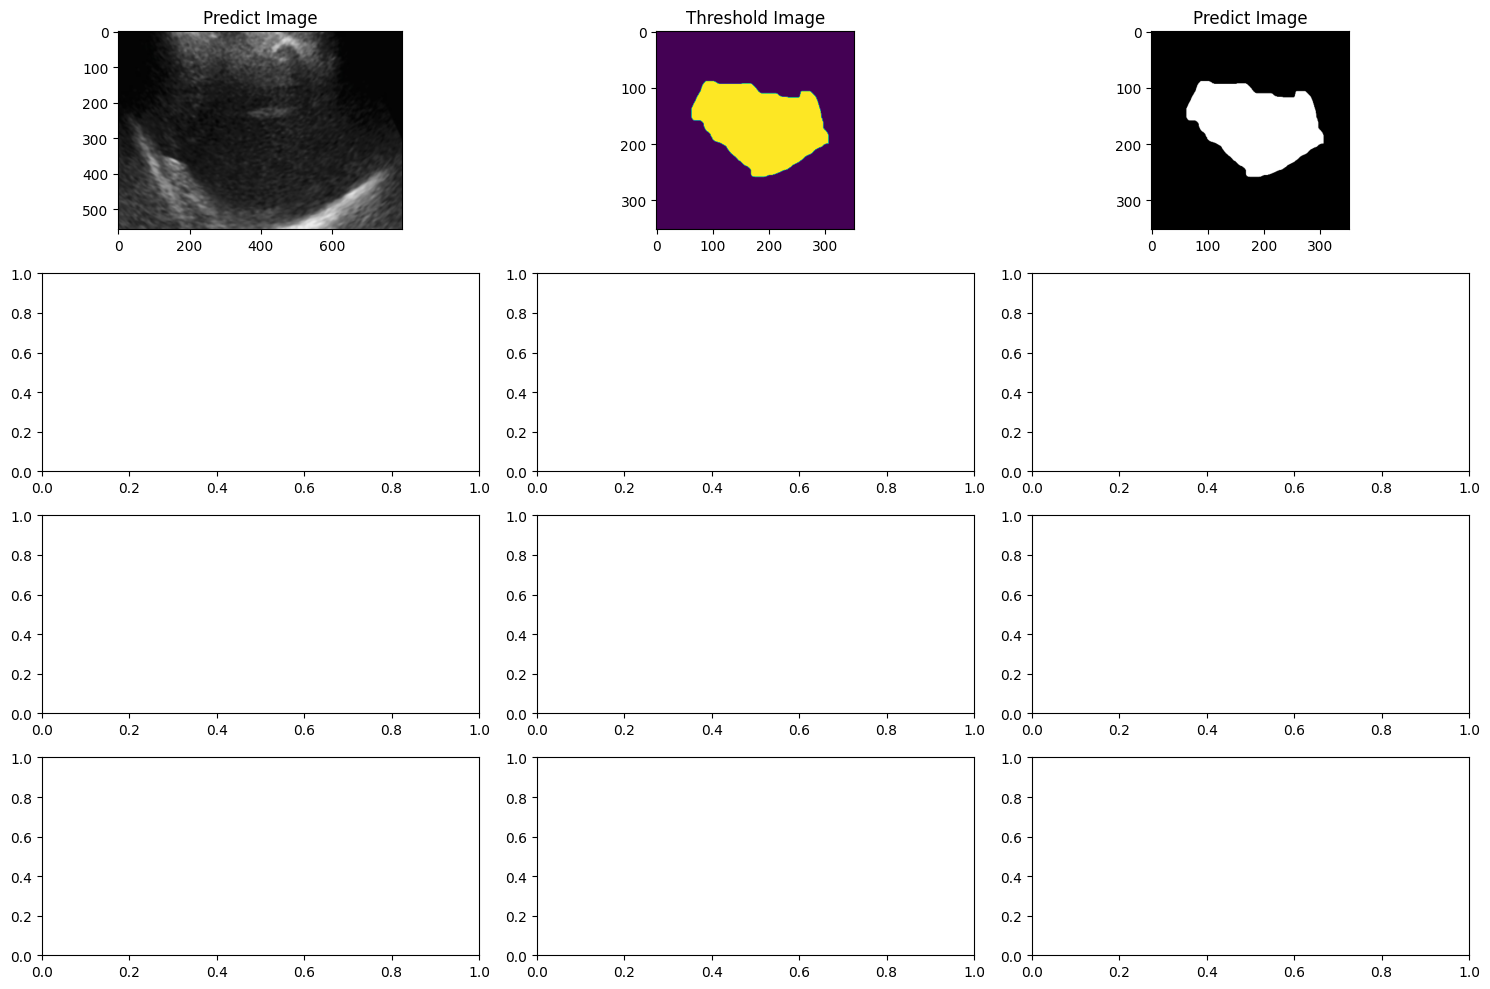

In [45]:
print("Loading the model")

model = tf.keras.models.load_model("ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28", custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_test = model.predict(X, batch_size=4)

fig, axs = plt.subplots(4, 3, figsize=(15, 10))

for i in range(len(prediction_test)):
# for i in range(0, 1):
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    
    pred = postproccessing(pred)
    
    axs[0, 2].imshow(pred, cmap='gray')
    axs[0, 2].set_title('Predict Image')
    
    pred = (pred * 255).astype(np.uint8)
    cv2.imwrite('Predictions/origin_' + str(i) + '.png', pred)
    
    img = cv2.imread('Predictions/origin_' + str(i) + '.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    _, binary_pred = cv2.threshold(pred, 100, 255, cv2.THRESH_BINARY)
    
    axs[0, 1].imshow(img)
    axs[0, 1].set_title('Threshold Image')
    
    contours, _ = cv2.findContours(binary_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        x, y, w, h = cv2.boundingRect(contours[0])

        roi = X[i][y:y+h, x:x+w]

        new_width = 799
        new_height = 556 
        resized_roi = cv2.resize(roi, (new_width, new_height))
        
        axs[0, 0].imshow(resized_roi, cmap='gray')
        axs[0, 0].set_title('Predict Image')
        
        resized_roi = (resized_roi * 255).astype(np.uint8)
        cv2.imwrite('Predictions/' + str(i+1) + '.png', resized_roi)
    else:
        print("No ROI found")

    # cv2.imwrite('Predictions/' + str(i) + '.png', pred)

plt.tight_layout()
plt.show()